Deep Active Learning with Contrastive Sampling

Deep Learning Project for Deep Learning Course (263-3210-00L)  
by Department of Computer Science, ETH Zurich, Autumn Semester 2021 

Authors:  
Sebastian Frey (sefrey@student.ethz.ch)  
Remo Kellenberger (remok@student.ethz.ch)  
Aron Schmied (aronsch@student.ethz.ch)  
Guney Tombak (gtombak@student.ethz.ch)  

# Latent Space Scatter Plot
This notebook is for visualizing the latent space and to observe how and which samples are sampled by our sampling strategy

In [1]:
import os
cwd = os.getcwd()
os.chdir("..")

from src.data import ActiveDataset
from src.model import Net
from src.base_models.samplers import CAL
from utils import ModelWriter
import yaml
import torch
from torch.nn.functional import normalize
import wandb
from utils import config_defaulter
from scipy.special import kl_div
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Load Model & Data

In [6]:
device = 'cpu'
dataset_name = 'fmnist'
init_lbl_ratio = 0.1
val_ratio = 0.1
seed = 42

yaml_path = os.path.join(cwd, 'cal_sampling_config.yaml')

with open(yaml_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
    config['cls']['output_size'] = 10

smp_config = {
  'name': 'cal',
  'n_neighs': 10,
  'neigh_dist': 'kldiv'
}

active_dataset = ActiveDataset(
    dataset_name,
    init_lbl_ratio=init_lbl_ratio,
    val_ratio=val_ratio,
    seed=seed
)

sampler = CAL(smp_config, device)

wandb.init(config=config, project="Deep Learning Project", entity="active_learners", mode="disabled") 
cfg = wandb.config

cfg = config_defaulter(cfg)

model = Net(cfg)
model.load_state_dict(
    torch.load(
        'vae_training/pretrained_models/fmnist_vae8_scatter/best_acc_weights.pth', 
        map_location=torch.device('cpu')
    )
)

Constructing Active Dataset for fmnist:


C:\Users\schmi\Envs\DLProj\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Global seed set to 42


Device is cpu
Seed has been set to 42...


<All keys matched successfully>

## Prepare Data

In [3]:
batch_size = 32
n_lab = 10
n_unlab = 10

labeled_data = active_dataset.get_loader('labeled', batch_size=batch_size)
unlabeled_data = active_dataset.get_loader('unlabeled', batch_size=batch_size)

z_lab = []
p_lab = []
z_unlab = []
p_unlab = []
c_lab = []
c_unlab = []

i = 0
for x, c in labeled_data:
    x = x.to(device)
    z = model.latent_param(x)
    z_lab.append(z)
    p = model.classify(x)
    p_lab.append(p)
    c_lab.append(c)
    i += 1
    if i > n_lab:
        break
i = 0
for x, c in unlabeled_data:
    x = x.to(device)
    z = model.latent_param(x)
    z_unlab.append(z)
    p = model.classify(x)
    p_unlab.append(p)
    c_unlab.append(c)
    i += 1
    if i > n_unlab:
        break
        
z_lab = torch.cat(z_lab)
p_lab = normalize(torch.exp(torch.cat(p_lab)), p=1)
c_lab = torch.cat(c_lab)
z_unlab = torch.cat(z_unlab)
p_unlab = normalize(torch.exp(torch.cat(p_unlab)), p=1)
c_unlab = torch.cat(c_unlab)

# filter
cls_filter = [0, 1, 2]
lab_filter = sum([c_lab == cls for cls in cls_filter]) == 1
unlab_filter = sum([c_unlab == cls for cls in cls_filter]) == 1
z_lab = z_lab[lab_filter]
p_lab = p_lab[lab_filter]
c_lab = c_lab[lab_filter]
z_unlab =  z_unlab[unlab_filter]
p_unlab =  p_unlab[unlab_filter]
c_unlab = c_unlab[unlab_filter]

## Apply CAL

In [4]:
def find_neighs(p, A, n_neigh):
    dist = neigh_dist_func(p, A)
    return torch.argsort(dist)[:n_neigh]

def gaussian_kl_div(mu_p, log_var_p, mu_q, log_var_q):
    """KL(Q||P) where Q, P ~ N(mu_1:k, diag(sigma2_1:k))"""
    return 0.5*(torch.exp(-log_var_q)*(torch.exp(log_var_p) + (mu_q-mu_p)**2) - 1 + log_var_q - log_var_p).sum(1)


def gaussian_symmetric_kl_div(mu_p, log_var_p, mu_q, log_var_q):
    """KL(Q||P)-KL(P||Q) where Q, P ~ N(mu_1:k, diag(sigma2_1:k))"""
    return 0.5*(torch.exp(-log_var_q)*(torch.exp(log_var_p) + (mu_q-mu_p)**2)
                + torch.exp(-log_var_p)*(torch.exp(log_var_q) + (mu_p-mu_q)**2) -2).sum(1)

neigh_dist = 'kldiv'
n_neighs = 10
acq_size = 5


dist_func = lambda y_l, y_p: kl_div(y_l.cpu().detach(), y_p.cpu().detach()).sum(1)

if neigh_dist == 'l2':
    neigh_dist_func = lambda p, A: torch.sum((p[..., 0] - A[..., 0]) ** 2, axis=1)
elif neigh_dist == 'kldiv':
    neigh_dist_func = lambda p, A: gaussian_kl_div(p[..., 0], p[..., 1], A[..., 0], A[..., 1])
elif neigh_dist == 'sym_kldiv':
    neigh_dist_func = lambda p, A: gaussian_symmetric_kl_div(p[..., 0], p[..., 1], A[..., 0], A[..., 1])
    


score = torch.zeros((len(p_unlab)))

for i in range(len(p_unlab)):
    idxs_neigh = find_neighs(z_unlab[i].unsqueeze(0), z_lab, n_neighs)
    score[i] = dist_func(p_lab[idxs_neigh], p_unlab[i].unsqueeze(0)).mean()

_, querry_indices = torch.topk(score, acq_size)
unlbld_idx = torch.where(torch.logical_not(active_dataset.lbld_mask))[0]

## Plot

C:\Users\schmi\Envs\DLProj\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\schmi\Envs\DLProj\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


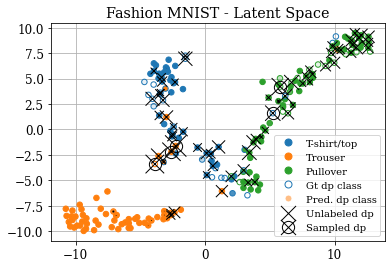

In [6]:
random_state = 0
def plt_props():
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.style'] = 'normal'
    plt.rcParams['font.variant'] = 'normal' 
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['figure.titlesize'] = 12
    plt.rcParams['figure.figsize'] = 6, 4
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 8
    plt.locator_params(axis='x', nbins=5)

all_latent = torch.cat((z_lab[..., 0],z_unlab[..., 0]))
all_classes = torch.cat((c_lab, torch.ones(len(z_unlab))*10))

X_embedded_mu = TSNE(n_components=2,random_state=random_state).fit_transform(all_latent)

cmap = plt.cm.get_cmap('tab20', 11)

gt_classes = torch.cat((c_lab, c_unlab))
pred = torch.cat((p_lab, p_unlab))[..., cls_filter]
pred_classes = pred.argmax(dim=1)
pred_prob = pred.max(dim=1)[0]

marker_colors = cmap(pred_classes.type(torch.int))
marker_colors[:, -1] *= pred_prob.detach().numpy()
marker_colors[:, -1] /= marker_colors[:, -1].max()
edge_colors = cmap(gt_classes.type(torch.int))

# -----------------------

plt_props()

plt.grid()
plt.rc('axes', axisbelow=True)

a = plt.scatter(
    x=X_embedded_mu[:, 0], 
    y=X_embedded_mu[:, 1], 
    c=marker_colors, 
    s=30, 
    edgecolor=edge_colors,
    cmap=cmap
)
b = plt.scatter(
    x=X_embedded_mu[-len(score):, 0], 
    y=X_embedded_mu[-len(score):, 1], 
    s=20*score,
    marker='x',
    c='#000000'
)
c = plt.scatter(
    x=X_embedded_mu[len(p_lab) + querry_indices, 0], 
    y=X_embedded_mu[len(p_lab) + querry_indices, 1], 
    s=150,
    marker='o',
    c=[0, 0, 0, 0],
    edgecolor='#000000'
)


legend_markers = [
    Line2D([0], [0], marker='o', color='w', markeredgecolor=cmap(0), markerfacecolor=cmap(0), markersize=7),
    Line2D([0], [0], marker='o', color='w', markeredgecolor=cmap(1), markerfacecolor=cmap(1), markersize=7),
    Line2D([0], [0], marker='o', color='w', markeredgecolor=cmap(2), markerfacecolor=cmap(2), markersize=7),
    Line2D([0], [0], marker='o', color='w', markeredgecolor=cmap(0), markerfacecolor='w', markersize=7),
    Line2D([0], [0], marker='o', color='w', markeredgecolor='w', markerfacecolor=list(cmap(1)[0:3])+ [0.5], markersize=7),
    b,
    (b, c)
]

legend_text = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Gt dp class',
    'Pred. dp class',
    'Unlabeled dp',
    'Sampled dp'
]

plt.legend(legend_markers, legend_text)
plt.title('Fashion MNIST - Latent Space')

plt.draw()
plt.savefig("scatter.pdf")
plt.show()